# Random Forest
In this notebook I will train a random forest for detection of erosion.

In [ ]:
# Adjust the frac parameter for loess smoothing
# to control the degree of smoothing applied to the scan data.
labeled_dir = "../../scandata/slices loess frac=0.18_labeled"

masks_path = "../stratified_k-fold_masks.npy"

DetectionNotClassification = True  # Set to True to replace all non-zero labels with 1

Libraries used:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)

In [3]:
all_masks = np.load(masks_path, allow_pickle=True)

# List all labeled files
labeled_files = [f for f in os.listdir(labeled_dir) if f.endswith("_slices_labeled.npy")]
selected_files = labeled_files  # Use all files by default

In [4]:
# Load features (X) and labels (y) for each file
all_X = []
all_y = []
for labeled_file in selected_files:
    data = np.load(os.path.join(labeled_dir, labeled_file), allow_pickle=True).item()
    slices = data["slices"]  # shape: (num_slices, max_points, 3)
    labels = data["labels"]  # shape: (num_slices,)

    X = slices[:, :, 2]  # shape: (num_slices, max_points)
    if DetectionNotClassification:
        y = (labels != 0).astype(int)
    else:
        y = labels  # keep original labels for multiclass
    all_X.append(X)
    all_y.append(y)

In [5]:
# Cross-validation using stratified k-Fold masks
n_folds = len(all_masks[0])
results = []

for file_idx, (X, y, masks) in enumerate(zip(all_X, all_y, all_masks)):
    file_results = []
    for fold_idx, val_mask in enumerate(masks):
        train_mask = ~val_mask
        X_train, y_train = X[train_mask], y[train_mask]
        X_val, y_val = X[val_mask], y[val_mask]

        # Train random forest classifier
        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)
        y_pred_class = model.predict(X_val)

        # Choose metric averaging based on classification type
        if DetectionNotClassification:
            avg = 'binary'
            roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1]) if len(np.unique(y_val)) > 1 else np.nan
        else:
            avg = 'weighted'
            # For multiclass, roc_auc_score needs special handling
            try:
                roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='weighted')
            except Exception:
                roc_auc = np.nan

        # Metrics (same as for benchmarks)
        metrics = {
            "accuracy": accuracy_score(y_val, y_pred_class),
            "precision": precision_score(y_val, y_pred_class, average=avg, zero_division=0),
            "recall": recall_score(y_val, y_pred_class, average=avg, zero_division=0),
            "f1": f1_score(y_val, y_pred_class, average=avg, zero_division=0),
            "roc_auc": roc_auc,
            "confusion_matrix": confusion_matrix(y_val, y_pred_class).tolist(),
            "fold": fold_idx,
            "file": selected_files[file_idx],
        }
        file_results.append(metrics)
    results.extend(file_results)

                                                    accuracy  precision  \
file                                                                      
221111_144114__binary_onlylines114378to117271 l...  0.806897   0.781013   
221111_144114__binary_onlylines145900to148050 l...  0.819345   0.745897   
221111_144114__binary_onlylines25660to28100 loe...  0.804082   0.734835   
221111_144114__binary_onlylines47178to50517 loe...  0.877250   0.865734   
221111_144114__binary_onlylines86841to90142 loe...  0.815785   0.745887   

                                                      recall        f1  \
file                                                                     
221111_144114__binary_onlylines114378to117271 l...  0.657143  0.708421   
221111_144114__binary_onlylines145900to148050 l...  0.593590  0.639616   
221111_144114__binary_onlylines25660to28100 loe...  0.573333  0.641057   
221111_144114__binary_onlylines47178to50517 loe...  0.620915  0.721535   
221111_144114__binary_onlyline

/tmp/ipykernel_77718/211072724.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


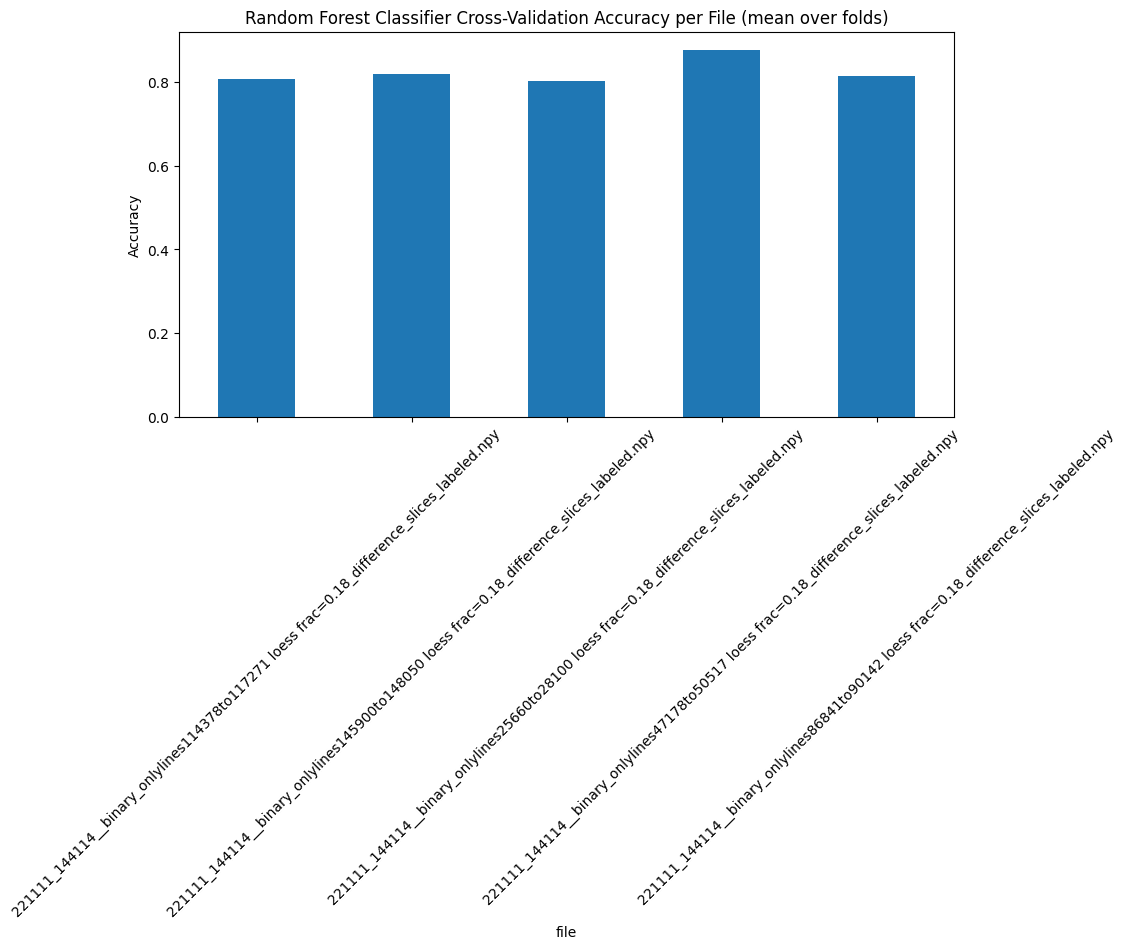

In [6]:
# Summarize results
df = pd.DataFrame(results)
print(df.groupby("file")[["accuracy", "precision", "recall", "f1", "roc_auc"]].mean())

# Optional: plot accuracy per file
df.groupby("file")["accuracy"].mean().plot.bar(rot=45, figsize=(10, 5))
plt.title("Random Forest Classifier Cross-Validation Accuracy per File (mean over folds)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

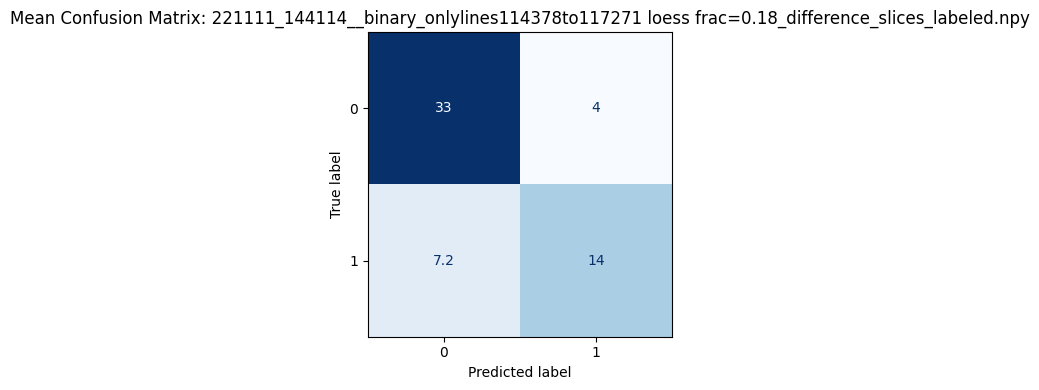

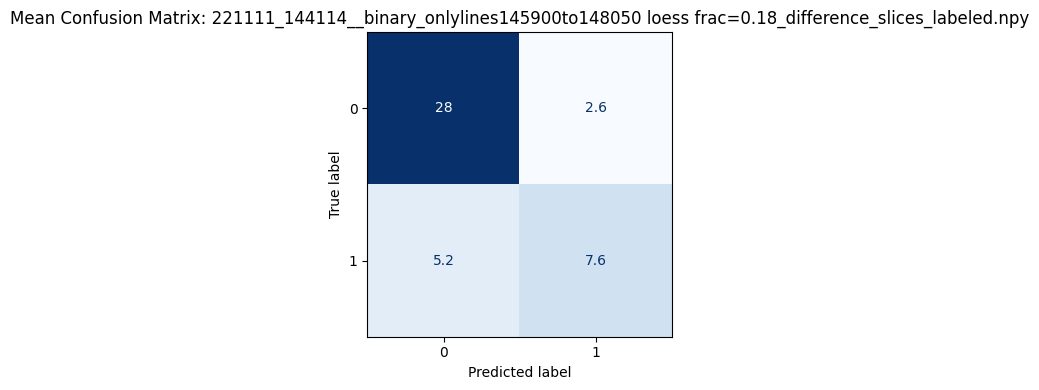

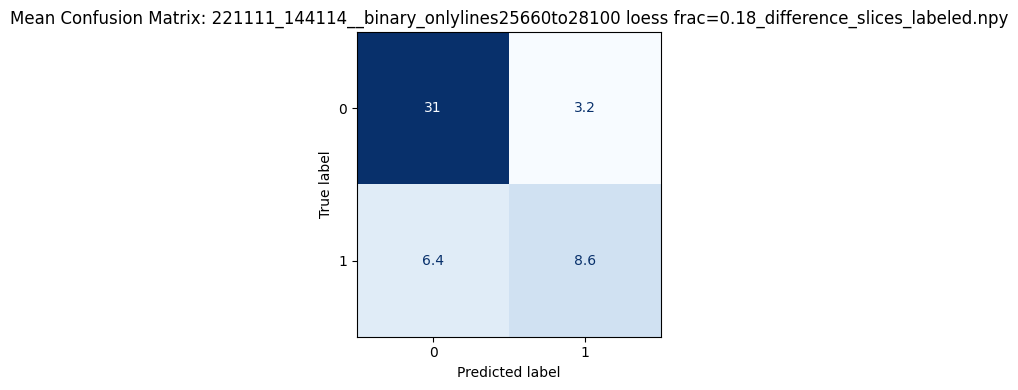

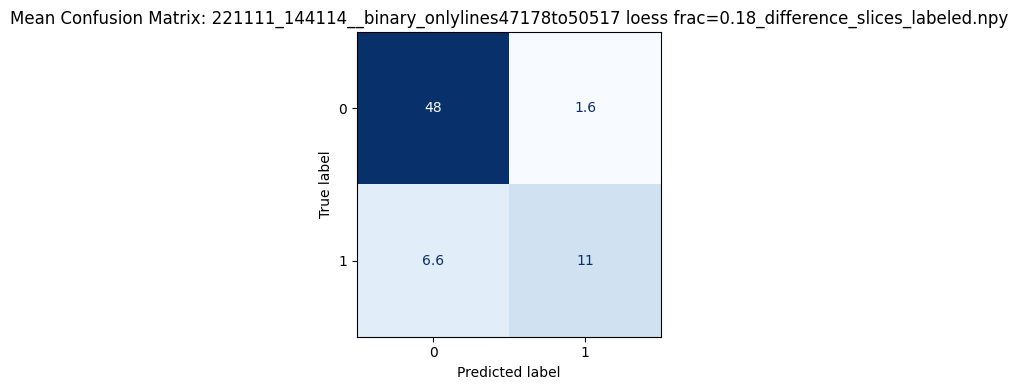

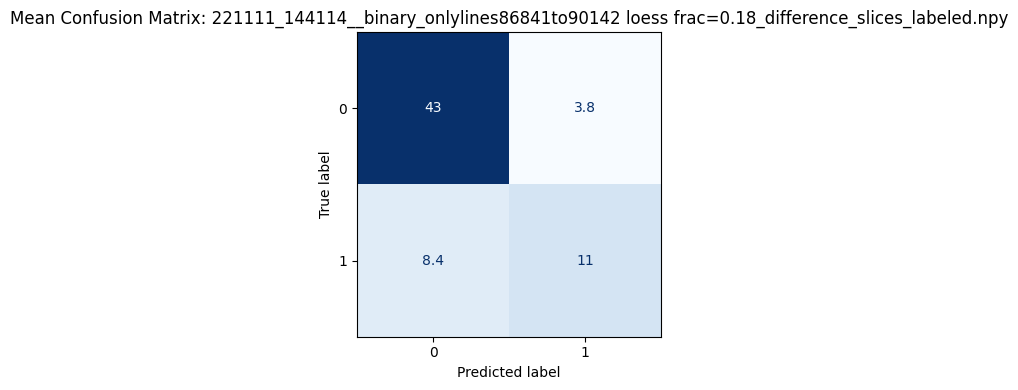

In [7]:
# Show confusion matrix for each file (mean over folds)
from sklearn.metrics import ConfusionMatrixDisplay

for file in df["file"].unique():
    cms = np.array([row for row in df[df["file"] == file]["confusion_matrix"]])
    mean_cm = np.mean(cms, axis=0)
    # Set display_labels to match the confusion matrix shape
    n_classes = mean_cm.shape[0]
    display_labels = [str(l) for l in range(n_classes)]
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(mean_cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(f"Mean Confusion Matrix: {file}")
    plt.tight_layout()
    plt.show()